# Q Learning (Off Policy)

We will be using **TD control method of Q Learning** on Cliff World environment as given below:  

![GridWorld](./images/cliffworld.png "Cliff World")


### Q Learning Update equation

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\DeclareMathOperator*{\max}{max} Q(S,A) \leftarrow Q(S,A) + \alpha * [ R + \gamma * \max_{A'} Q(S’,A’) – Q(S,A)] $$



In [9]:
# Initial imports and environment setup
import sys
import gymnasium as gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Q- Learning agent class
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, best_next_action) \
                       - self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [11]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [12]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [13]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

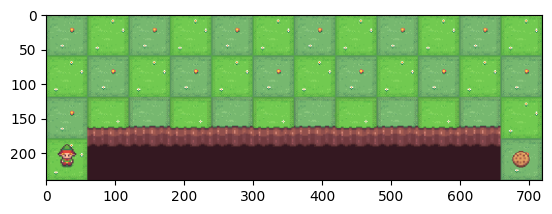

In [14]:
# create cliff world environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [15]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.nA))

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

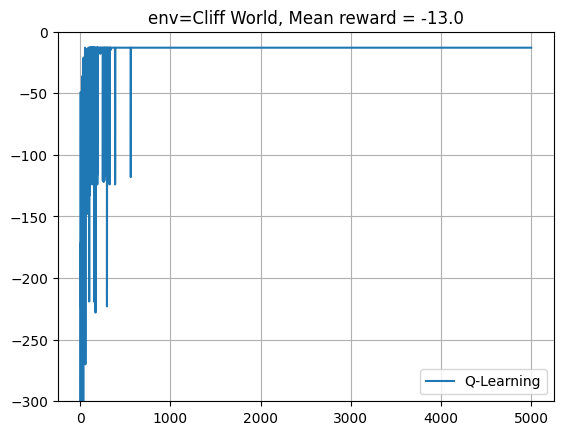

In [16]:
# Plot rewards
plot_rewards("Cliff World",rewards, 'Q-Learning')

In [18]:
# print policy 
print_policy(env, agent)

 <  <  ^  ^  >  >  >  >  >  >  v  > 
 v  ^  >  >  ^  >  v  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Q Learning for "Taxi" environment 

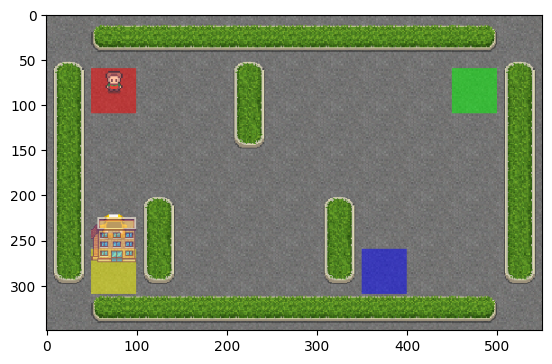

In [19]:
# create taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

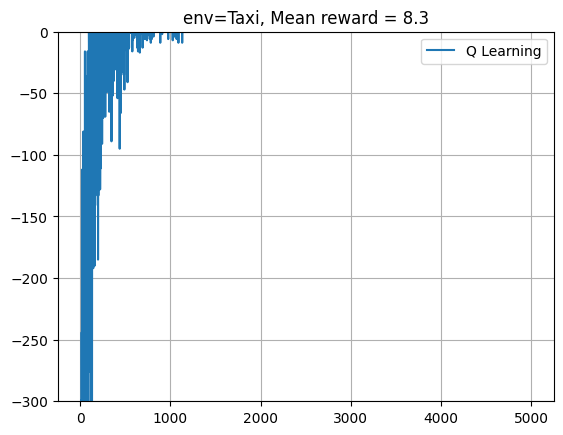

In [20]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

#plot reward graph
plot_rewards("Taxi", rewards, 'Q Learning')

### Conclusion

We see that Q Agent learns the optimal policy by 500 episodes of training in case of Cliff World. As the learnt policy does not have any exploration, the agent learns the shortest route of walking across the maze, right on the row just above cliff. As the actions are deterministic and there is no exploration, the agent has no chance of falling into cliff when it takes a RIGHT action in a cell next to the cliff. Therefore, it learns to take the shortest route towards goal. 